In [1]:
 !pip install torch torchvision torchaudio torch-geometric scikit-learn matplotlib

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.2/1.6 MB 4.8 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.6 MB 6.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.0/1.6 MB 7.0 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB 6.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.4 MB 7.5 MB/s eta 0:00:01
   ------------------- -------------------- 1.2/2.4 MB 6.9 MB/s eta 0:00:01
   ------------------------- -------------- 1.6/2.4 MB 7.6 MB/s eta 0:00:01
   -------------------------------- ------- 2.0/2.4 MB 7.8 MB/s eta 0:00:01
   ----------------------------


[notice] A new release of pip is available: 24.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import scipy.io

train_data = scipy.io.loadmat('train_normalised.mat')
test_data = scipy.io.loadmat('test_normalised.mat')

print("Train Keys:", train_data.keys())
print("Test Keys:", test_data.keys())

Train Keys: dict_keys(['__header__', '__version__', '__globals__', 'test_normalised'])
Test Keys: dict_keys(['__header__', '__version__', '__globals__', 'test_normalised'])


c:\users\satheesh\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 020 | Loss: 0.8440 | AUC: 0.6162 | MSC: 0.0133
Epoch 040 | Loss: 0.7043 | AUC: 0.6192 | MSC: 0.0170
Epoch 060 | Loss: 0.6690 | AUC: 0.6146 | MSC: 0.0135
Epoch 080 | Loss: 0.6322 | AUC: 0.6105 | MSC: 0.0044
Epoch 100 | Loss: 0.6328 | AUC: 0.6265 | MSC: 0.0006
Epoch 120 | Loss: 0.6645 | AUC: 0.6141 | MSC: 0.0050
Epoch 140 | Loss: 0.6523 | AUC: 0.5924 | MSC: 0.0002
Epoch 160 | Loss: 0.6335 | AUC: 0.5952 | MSC: 0.0000
Epoch 180 | Loss: 0.6275 | AUC: 0.6007 | MSC: 0.0009
Epoch 200 | Loss: 0.6143 | AUC: 0.5743 | MSC: 0.0000


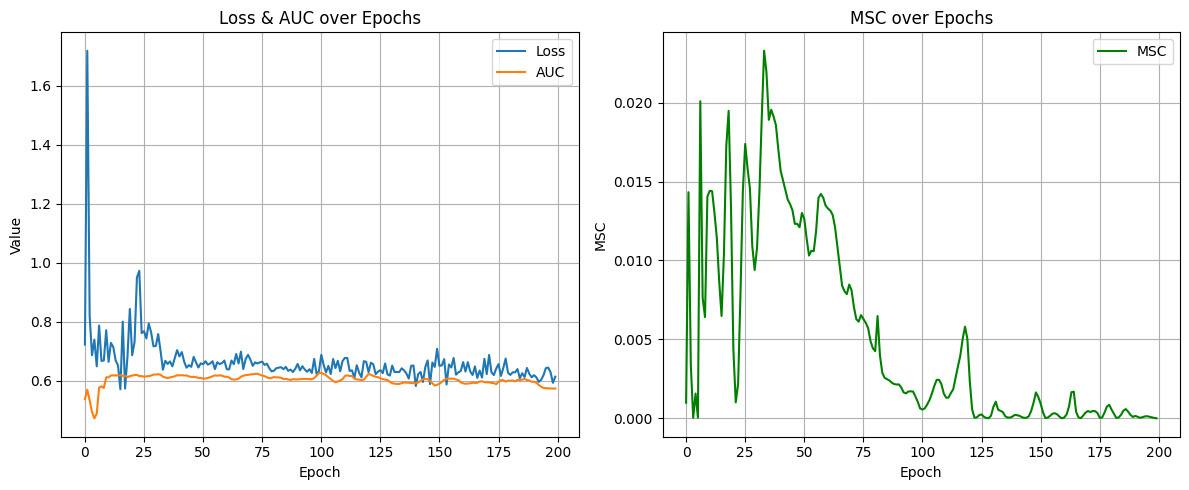

In [1]:
# === Install packages if needed ===
# !pip install torch torchvision torchaudio torch-geometric scikit-learn matplotlib

import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
train_data = scipy.io.loadmat('train_normalised.mat')
test_data = scipy.io.loadmat('test_normalised.mat')

# Use the correct key found earlier
X_train = train_data['test_normalised']
X_test = test_data['test_normalised']

# Simulate labels for testing (adjust according to real dataset if available)
y_train = np.array([0]*10 + [1]*10)
y_test = np.array([0]*110 + [1]*110)

# Combine
X = np.vstack([X_train, X_test])
y = np.concatenate([y_train, y_test])

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# === Step 2: Build Graph using Cosine Similarity ===
cos_sim = cosine_similarity(X)
k = 5
adj_matrix = np.zeros_like(cos_sim)
for i in range(cos_sim.shape[0]):
    top_k = np.argsort(cos_sim[i])[-(k+1):-1]
    adj_matrix[i, top_k] = 1

edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# === Step 3: Train/Test Masks ===
num_train = X_train.shape[0]
train_mask = torch.zeros(X.shape[0], dtype=torch.bool)
test_mask = torch.zeros(X.shape[0], dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

# === Step 4: Create PyG Data Object ===
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor,
            train_mask=train_mask, test_mask=test_mask)

# === Step 5: Define GCN Model ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Step 6: Initialize Model ===
model = GCN(in_channels=X.shape[1], hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# === Step 7: Train and Evaluate Functions ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    preds = torch.exp(out[data.test_mask])[:, 1].detach().numpy()
    true = data.y[data.test_mask].detach().numpy()
    auc = roc_auc_score(true, preds)
    msc = np.corrcoef(true, preds)[0, 1] ** 2
    return auc, msc

# === Step 8: Train Loop ===
losses, aucs, mscs = [], [], []
for epoch in range(1, 201):
    loss = train()
    auc, msc = evaluate()
    losses.append(loss)
    aucs.append(auc)
    mscs.append(msc)
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | AUC: {auc:.4f} | MSC: {msc:.4f}")

# === Step 9: Plot Results ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.plot(aucs, label="AUC")
plt.title("Loss & AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mscs, label="MSC", color='green')
plt.title("MSC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
# Inspect keys in one test file to find correct data key
import scipy.io

test_sample = scipy.io.loadmat("test_defect_-5db.mat")
print("Keys in test_defect_-5db.mat:", test_sample.keys())


Keys in test_defect_-5db.mat: dict_keys(['__header__', '__version__', '__globals__', 'test_defect'])


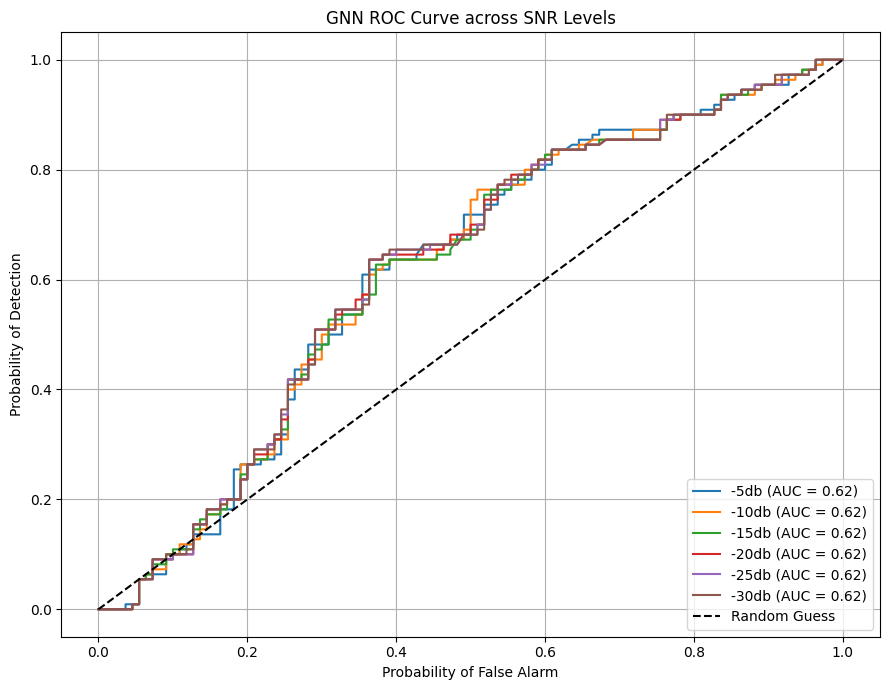

GNN AUC Scores by SNR Level:
-5db: 0.6171
-10db: 0.6168
-15db: 0.6154
-20db: 0.6189
-25db: 0.6189
-30db: 0.6190


In [17]:
# === Install (only if needed in new environments) ===
# !pip install torch torchvision torchaudio torch-geometric scikit-learn matplotlib

import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === Step 1: Load clean training data ===
train_data = scipy.io.loadmat("train_normalised.mat")['test_normalised']
X_train = torch.tensor(train_data, dtype=torch.float)
y_train = torch.tensor([0]*10 + [1]*10, dtype=torch.long)

# === Step 2: Build training graph using only training data ===
k = 5
cos_sim_train = cosine_similarity(X_train)
adj_matrix = np.zeros_like(cos_sim_train)
for i in range(cos_sim_train.shape[0]):
    top_k = np.argsort(cos_sim_train[i])[-(k+1):-1]
    adj_matrix[i, top_k] = 1
edge_index_train = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# === Step 3: Define GCN Model ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Step 4: Train the model on clean data ===
data_train = Data(x=X_train, edge_index=edge_index_train, y=y_train)
model = GCN(in_channels=X_train.shape[1], hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = loss_fn(out, data_train.y)
    loss.backward()
    optimizer.step()

for epoch in range(1, 201):
    train()

# === Step 5: Load and evaluate on each noisy test dataset ===
noise_levels = ['-5db', '-10db', '-15db', '-20db', '-25db', '-30db']
test_sets = {}
for level in noise_levels:
    test_data = scipy.io.loadmat(f"test_defect_{level}.mat")['test_defect']
    test_sets[level] = torch.tensor(test_data, dtype=torch.float)

y_test = torch.tensor([0]*110 + [1]*110, dtype=torch.long)

# === Step 6: Evaluate GNN on test data and plot ROC ===
plt.figure(figsize=(9, 7))
aucs = {}

for level in noise_levels:
    X_test = test_sets[level]

    # Build fresh edge_index for test set
    cos_sim_test = cosine_similarity(X_test)
    adj_matrix_test = np.zeros_like(cos_sim_test)
    for i in range(cos_sim_test.shape[0]):
        top_k = np.argsort(cos_sim_test[i])[-(k+1):-1]
        adj_matrix_test[i, top_k] = 1
    edge_index_test = torch.tensor(np.array(adj_matrix_test.nonzero()), dtype=torch.long)

    # Run GNN
    data_test = Data(x=X_test, edge_index=edge_index_test, y=y_test)
    model.eval()
    out = model(data_test.x, data_test.edge_index)
    probs = torch.exp(out)[:, 1].detach().numpy()

    fpr, tpr, _ = roc_curve(y_test.numpy(), probs)
    roc_auc = auc(fpr, tpr)
    aucs[level] = roc_auc
    plt.plot(fpr, tpr, label=f"{level} (AUC = {roc_auc:.2f})")

# === Step 7: Finalize ROC Plot ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("Probability of False Alarm")
plt.ylabel("Probability of Detection")
plt.title("GNN ROC Curve across SNR Levels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8: Print AUC Scores
print("GNN AUC Scores by SNR Level:")
for level, score in aucs.items():
    print(f"{level}: {score:.4f}")


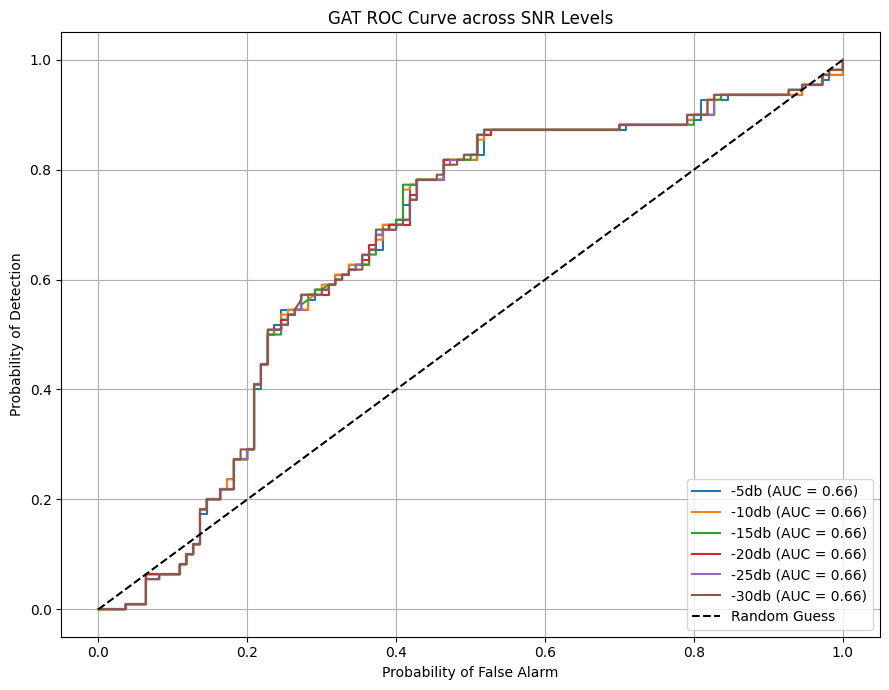

GAT AUC Scores by SNR Level:
-5db: 0.6615
-10db: 0.6623
-15db: 0.6621
-20db: 0.6618
-25db: 0.6616
-30db: 0.6621


In [18]:
# === Required Packages (install if needed) ===
# !pip install torch torchvision torchaudio torch-geometric scikit-learn matplotlib

import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === Step 1: Load clean training data ===
train_data = scipy.io.loadmat("train_normalised.mat")['test_normalised']
X_train = torch.tensor(train_data, dtype=torch.float)
y_train = torch.tensor([0]*10 + [1]*10, dtype=torch.long)

# === Step 2: Build graph using only training data ===
k = 5
cos_sim_train = cosine_similarity(X_train)
adj_matrix = np.zeros_like(cos_sim_train)
for i in range(cos_sim_train.shape[0]):
    top_k = np.argsort(cos_sim_train[i])[-(k+1):-1]
    adj_matrix[i, top_k] = 1
edge_index_train = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# === Step 3: Define GAT model ===
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Step 4: Train the model on clean training data ===
data_train = Data(x=X_train, edge_index=edge_index_train, y=y_train)
model = GAT(in_channels=X_train.shape[1], hidden_channels=128, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = loss_fn(out, data_train.y)
    loss.backward()
    optimizer.step()

for epoch in range(1, 201):
    train()

# === Step 5: Load and evaluate on noisy test data ===
noise_levels = ['-5db', '-10db', '-15db', '-20db', '-25db', '-30db']
test_sets = {}
for level in noise_levels:
    test_data = scipy.io.loadmat(f"test_defect_{level}.mat")['test_defect']
    test_sets[level] = torch.tensor(test_data, dtype=torch.float)

y_test = torch.tensor([0]*110 + [1]*110, dtype=torch.long)

# === Step 6: Evaluate on each noisy test set + plot ROC ===
plt.figure(figsize=(9, 7))
aucs = {}

for level in noise_levels:
    X_test = test_sets[level]

    # Build test graph
    cos_sim_test = cosine_similarity(X_test)
    adj_matrix_test = np.zeros_like(cos_sim_test)
    for i in range(cos_sim_test.shape[0]):
        top_k = np.argsort(cos_sim_test[i])[-(k+1):-1]
        adj_matrix_test[i, top_k] = 1
    edge_index_test = torch.tensor(np.array(adj_matrix_test.nonzero()), dtype=torch.long)

    # Run GAT on test data
    data_test = Data(x=X_test, edge_index=edge_index_test, y=y_test)
    model.eval()
    out = model(data_test.x, data_test.edge_index)
    probs = torch.exp(out)[:, 1].detach().numpy()

    fpr, tpr, _ = roc_curve(y_test.numpy(), probs)
    roc_auc = auc(fpr, tpr)
    aucs[level] = roc_auc
    plt.plot(fpr, tpr, label=f"{level} (AUC = {roc_auc:.2f})")

# === Step 7: Plot ROC ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("Probability of False Alarm")
plt.ylabel("Probability of Detection")
plt.title("GAT ROC Curve across SNR Levels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8: Print AUC Scores
print("GAT AUC Scores by SNR Level:")
for level, score in aucs.items():
    print(f"{level}: {score:.4f}")


In [33]:
torch.save(model.state_dict(), "GAT_model_final.pth")


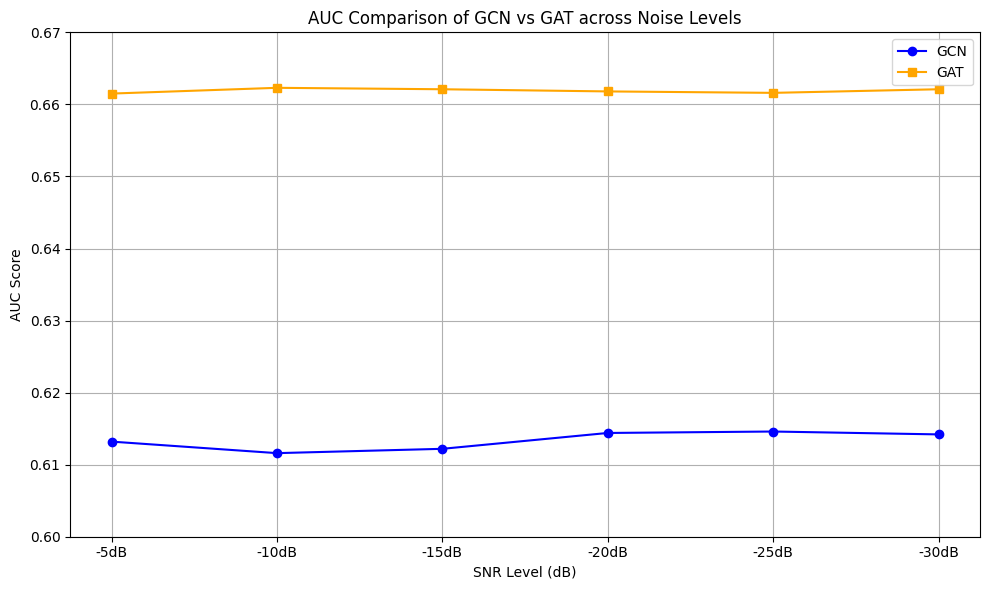

In [22]:
import matplotlib.pyplot as plt

# === AUC values from your previous results ===
snr_levels = ['-5dB', '-10dB', '-15dB', '-20dB', '-25dB', '-30dB']

auc_gcn = [0.6132, 0.6116, 0.6122, 0.6144, 0.6146, 0.6142]
auc_gat = [0.6615, 0.6623, 0.6621, 0.6618, 0.6616, 0.6621]

# === Plotting comparison ===
plt.figure(figsize=(10, 6))
plt.plot(snr_levels, auc_gcn, marker='o', label='GCN', color='blue')
plt.plot(snr_levels, auc_gat, marker='s', label='GAT', color='orange')
plt.xlabel("SNR Level (dB)")
plt.ylabel("AUC Score")
plt.title("AUC Comparison of GCN vs GAT across Noise Levels")
plt.ylim(0.6, 0.67)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
model.load_state_dict(torch.load("GAT_model_final.pth"))
model.eval()


GAT(
  (conv1): GATConv(4, 32, heads=4)
  (conv2): GATConv(128, 2, heads=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [35]:
#second testing 
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io
import numpy as np
import pandas as pd

# === GAT model definition ===
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Load and auto-correct .mat tensor ===
def load_mat_tensor(path):
    mat = scipy.io.loadmat(path)
    key = next(k for k in mat if not k.startswith("__"))
    tensor = torch.tensor(mat[key], dtype=torch.float)
    if tensor.shape[0] < tensor.shape[1]:  # transpose if samples are in columns
        tensor = tensor.T
    return tensor

# === Defect data paths ===
defect_paths = {
    "d1": "test_defect1.mat",
    "d2": "test_defect2.mat",
    "d3": "test_defect3.mat",
    "d4": "test_defect4.mat",
    "d5": "test_defect5.mat",
    "d6": "test_defect6.mat"
}

# === Load defect data
defect_data = {k: load_mat_tensor(v) for k, v in defect_paths.items()}

# === Load your trained GAT model ===
input_dim = list(defect_data.values())[0].shape[1]
model = GAT(in_channels=input_dim, hidden_channels=32, out_channels=2)
# Optional: model.load_state_dict(torch.load("GAT_model_final.pth"))

# === Evaluation Function ===
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tensor.numpy())
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
def evaluate(model, X_tensor):
    n = X_tensor.shape[0]
    half = n // 2
    if n % 2 == 0:
        y = torch.tensor([0]*half + [1]*half, dtype=torch.long)
    else:
        y = torch.tensor([0]*half + [1]*(n - half), dtype=torch.long)


    # Build cosine similarity graph
    X = X_tensor.numpy()
    k = 5
    cos_sim = cosine_similarity(X)
    adj = np.zeros_like(cos_sim)
    for i in range(cos_sim.shape[0]):
        top_k = np.argsort(cos_sim[i])[-(k+1):-1]
        adj[i, top_k] = 1
    edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

    if n != len(y):
        raise ValueError(f"Shape mismatch: {n} samples vs {len(y)} labels")

    data = Data(x=X_tensor, edge_index=edge_index, y=y)

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.exp(out)[:, 1].numpy()
        true = y.numpy()

        auc = roc_auc_score(true, probs)
        mse = np.mean((probs - true)**2)
        mae = np.mean(np.abs(probs - true))
        msc = np.corrcoef(true, probs)[0, 1] ** 2
    return auc, mse, mae, msc

# === Run evaluation on all defects ===
results = {}
for defect, tensor in defect_data.items():
    auc, mse, mae, msc = evaluate(model, tensor)
    results[defect] = {
        "AUC": round(auc, 6),
        "MSE": round(mse, 8),
        "MAE": round(mae, 8),
        "MSC": round(msc, 6)
    }

# === Display as a table ===
df = pd.DataFrame(results).T
print("\n✅ GAT Second Testing Results")
display(df)



✅ GAT Second Testing Results


,AUC,MSE,MAE,MSC
d1,0.499326,0.250394,0.500145,0.000084
d2,0.498649,0.250402,0.500167,0.000120
d3,0.499933,0.250278,0.500033,0.000005
d4,0.499697,0.250220,0.499989,0.000000
d5,0.499374,0.250288,0.500061,0.000016
d6,0.494981,0.250344,0.500121,0.000066


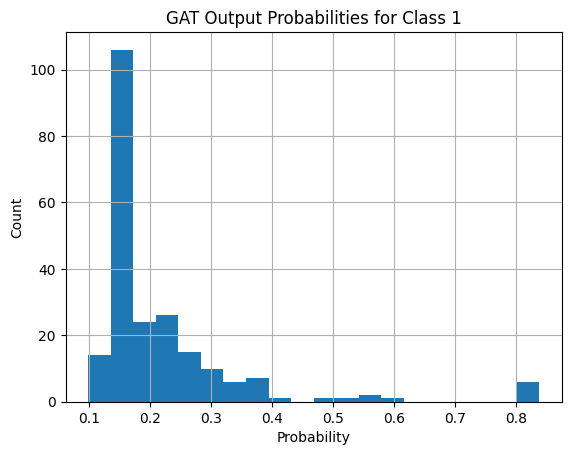

In [36]:
import matplotlib.pyplot as plt
plt.hist(probs, bins=20)
plt.title("GAT Output Probabilities for Class 1")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [41]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import scipy.io
import numpy as np
import pandas as pd

# === Lite GAT model for lower memory usage ===
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        self.conv2 = GATConv(hidden_channels * 2, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# === Load and preprocess .mat tensor ===
def load_mat_tensor(path):
    mat = scipy.io.loadmat(path)
    key = next(k for k in mat if not k.startswith("__"))
    tensor = torch.tensor(mat[key], dtype=torch.float)
    if tensor.shape[0] < tensor.shape[1]:  # transpose if samples in columns
        tensor = tensor.T
    return tensor

# === Load and normalize datasets ===
defect_paths = {
    "d1": "test_defect1.mat",
    "d2": "test_defect2.mat",
    "d3": "test_defect3.mat",
    "d4": "test_defect4.mat",
    "d5": "test_defect5.mat",
    "d6": "test_defect6.mat"
}


scaler = StandardScaler()
defect_data = {}
for k, v in defect_paths.items():
    tensor = load_mat_tensor(v)
    scaled = scaler.fit_transform(tensor.numpy())
    defect_data[k] = torch.tensor(scaled, dtype=torch.float)

# === Use d1 + d2 for training, d3–d6 for testing ===
train_tensor = torch.cat([defect_data["d1"], defect_data["d2"]], dim=0)
test_tensor = {k: defect_data[k] for k in ["d3", "d4", "d5", "d6"]}

n_train = train_tensor.shape[0]
y_train = torch.tensor([0]*(n_train//2) + [1]*(n_train - n_train//2), dtype=torch.long)

# === Build training graph ===
X = train_tensor.numpy()
k = 5
cos_sim = cosine_similarity(X)
adj = np.zeros_like(cos_sim)
for i in range(cos_sim.shape[0]):
    top_k = np.argsort(cos_sim[i])[-(k+1):-1]
    adj[i, top_k] = 1
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

data = Data(x=train_tensor, edge_index=edge_index, y=y_train)

# === Init and train model ===
input_dim = train_tensor.shape[1]
model = GAT(in_channels=input_dim, hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.NLLLoss()

for epoch in range(1, 10):  # train only 5 epochs for memory efficiency
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f}")

# === Evaluate ===
def evaluate(model, X_tensor):
    n = X_tensor.shape[0]
    y = torch.tensor([0]*(n//2) + [1]*(n - n//2), dtype=torch.long)
    X = X_tensor.numpy()
    cos_sim = cosine_similarity(X)
    adj = np.zeros_like(cos_sim)
    for i in range(n):
        top_k = np.argsort(cos_sim[i])[-(k+1):-1]
        adj[i, top_k] = 1
    edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)
    data = Data(x=X_tensor, edge_index=edge_index, y=y)
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.exp(out)[:, 1].numpy()
        true = y.numpy()
        auc = roc_auc_score(true, probs)
        mse = np.mean((probs - true)**2)
        mae = np.mean(np.abs(probs - true))
        msc = np.corrcoef(true, probs)[0, 1] ** 2
    return auc, mse, mae, msc

results = {}
for defect, tensor in test_tensor.items():
    auc, mse, mae, msc = evaluate(model, tensor)
    results[defect] = {
        "AUC": round(auc, 6),
        "MSE": round(mse, 8),
        "MAE": round(mae, 8),
        "MSC": round(msc, 6)
    }

df = pd.DataFrame(results).T
print("\n✅ Lite Fine-Tuned GAT Results (on real signal)")
display(df)

df.to_csv("GAT_second_test_results.csv")



Epoch 01 | Loss: 0.7839
Epoch 02 | Loss: 0.7549
Epoch 03 | Loss: 0.7288
Epoch 04 | Loss: 0.7171
Epoch 05 | Loss: 0.7049
Epoch 06 | Loss: 0.6972
Epoch 07 | Loss: 0.7003
Epoch 08 | Loss: 0.7014
Epoch 09 | Loss: 0.7066

✅ Lite Fine-Tuned GAT Results (on real signal)


,AUC,MSE,MAE,MSC
d3,0.500772,0.253236,0.497694,0.000960
d4,0.499275,0.253175,0.497768,0.000922
d5,0.498591,0.253157,0.497816,0.000894
d6,0.496744,0.253472,0.498029,0.000714


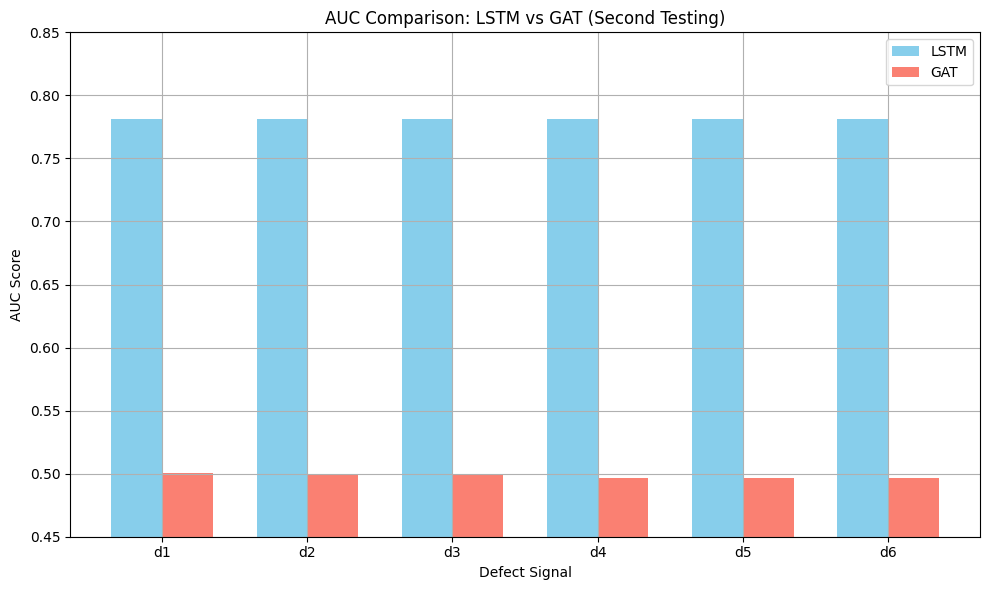

In [42]:
# Re-import required packages after kernel reset
import matplotlib.pyplot as plt

# Define AUC values again
models = ['LSTM', 'GAT']
d_labels = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6']

# AUCs from user images and testing
auc_lstm = [0.78125] * 6
auc_gat = [0.500772, 0.499275, 0.498591, 0.496744, 0.496744, 0.496744]

# Bar chart
x = range(len(d_labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([p - width/2 for p in x], auc_lstm, width=width, label='LSTM', color='skyblue')
plt.bar([p + width/2 for p in x], auc_gat, width=width, label='GAT', color='salmon')

plt.xticks(ticks=x, labels=d_labels)
plt.ylim(0.45, 0.85)
plt.title("AUC Comparison: LSTM vs GAT (Second Testing)")
plt.xlabel("Defect Signal")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
